In [0]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/

!kaggle datasets download -d shadabhussain/flickr8k
!unzip -q flickr8k.zip
!unzip -q Flickr_Data.zip

!mv Flickr_Data/Images .
!mv Flickr_Data/Flickr_TextData/Flickr8k.token.txt captions.txt
!rm -r flickr8k.zip Flickr_Data.zip Flickr_Data model_weights.h5 train_encoded_images.p

!kaggle datasets download -d watts2/glove6b50dtxt
!unzip -q glove6b50dtxt.zip
!rm -r glove6b50dtxt.zip 

 98% 1.07G/1.09G [00:08<00:00, 128MB/s]
100% 1.09G/1.09G [00:08<00:00, 136MB/s]
 84% 57.0M/67.7M [00:00<00:00, 54.7MB/s]
100% 67.7M/67.7M [00:00<00:00, 87.0MB/s]


In [0]:
import pandas as pd
import os
allimage = os.listdir('Images')
data = pd.read_csv('captions.txt', sep='\t',header=None, names= ['image','caption'])
data.image = data.image.apply( lambda x: x.split('jpg')[0]+'jpg' )
data['avail'] = data.image.apply( lambda x: x in allimage )
data = data[ data.avail==True ]
data = data.dropna()
print(data.shape)
data.head()

(40455, 3)


,image,caption,avail
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,True
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,True
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,True
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,True
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,True


In [0]:
import gc
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
word_counter = defaultdict(int)

table = str.maketrans('', '', string.punctuation,)
def preprocesCaption( caption):
  caption = caption.lower() #to lower case
  caption = caption.translate(table) #remove punctuations
  caption = caption.split() # convert to words
  caption = [ w for w in caption if len(w) > 1 ] #remove dangling 'a' and 's'
  caption = [ w for w in caption if w.isalpha()  ] #keep only words with alphabets
  caption = [ lemmatizer.lemmatize(w) for w in caption ]
  for w in caption: word_counter[w]+=1
  return ' '.join(caption)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
from tqdm import tqdm
from collections import defaultdict

words = set()
words.update( ('<S>','</S>') )
mx = 0

images = defaultdict(list)
for img in tqdm(data.image.unique()):
  for comment in data[data.image == img ].caption.values:
    caption = preprocesCaption(comment)
    caption = [ w for w in caption.split() if word_counter[w]>=10 ]  #taking words whose count atleast 10
    words.update( caption )
    mx = max(mx,len(caption)+2)
    images[img].append( '<S> '+" ".join(caption)+' </S>' )

print(len(images), len(words),mx)
del data; gc.collect()

100%|██████████| 8091/8091 [00:23<00:00, 350.96it/s]


8091 1748 30


29600

In [0]:
import numpy as np
import os

ind_to_word={}
word_to_ind = {}
for i,w in enumerate(words):
  ind_to_word[i+1] = w
  word_to_ind[w] = i+1

In [0]:
from keras.preprocessing.sequence import pad_sequences

images_caption = defaultdict(list)
MAX_SEQ_LEN = 25
VOCAB_SIZE = len(words)+1

for img in images.keys():
  arr = []
  for caption in images[img]:
    arr.append( [ word_to_ind.get(word) for word in caption.split() ] )
  images_caption[img] = arr

In [0]:
embeddings = np.zeros(shape=(VOCAB_SIZE,50))
with open('glove.6B.50d.txt','r') as glov:
  for line in glov.readlines():
    line = line.split()
    if line[0] in words:
      embeddings[word_to_ind[line[0]]] = list(map(float,line[1:]))
embeddings.shape

(1749, 50)

In [0]:
import random
data = []
for key in images_caption.keys():
  for caption in images_caption[key]:
    data.append( (key, caption) )
random.shuffle(data)
del images_caption; gc.collect()
data[:2]

[('3169276423_6918dd4da1.jpg',
  [321, 40, 672, 1312, 656, 447, 1630, 992, 227, 634, 672, 672, 774, 534]),
 ('3038045802_93f2cd5fbc.jpg',
  [321,
   679,
   256,
   149,
   1741,
   846,
   770,
   1551,
   41,
   829,
   453,
   615,
   1155,
   1741,
   534])]

In [0]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
Xtext, Ximage, ytext = [],[],[]
for image,text in tqdm(data):
    for i in range(1,len(text)):
        in_text, out_text = text[:i], text[i]
        in_text = pad_sequences([in_text],maxlen=MAX_SEQ_LEN,padding='pre').flatten()
        out_text = to_categorical(out_text,num_classes = VOCAB_SIZE)
        Xtext.append(in_text)
        Ximage.append(image)
        ytext.append(out_text)
Xtext  = np.array(Xtext)
Ximage = np.array(Ximage)
ytext  = np.array(ytext)
print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))

100%|██████████| 40455/40455 [00:12<00:00, 3135.20it/s]


 (383850, 25) (383850,) (383850, 1749)


In [0]:
from sklearn.model_selection import train_test_split
VALIDATION_SPLIT = 0.2
num_rec = int(len(ytext)*VALIDATION_SPLIT)
def split(dt,rec):
  return dt[:rec],dt[rec:]

Ttext, Vtext = split(Xtext,num_rec)
Timage, Vimage = split(Ximage,num_rec)
Ty,Vy = split(ytext,num_rec)
del Xtext,Ximage,ytext; gc.collect()
len(Ttext),len(Vtext)

(76770, 307080)

In [0]:
"https://fairyonice.github.io/Develop_an_image_captioning_deep_learning_model_using_Flickr_8K_data.html#A-bit-more-detail:"

'https://fairyonice.github.io/Develop_an_image_captioning_deep_learning_model_using_Flickr_8K_data.html#A-bit-more-detail:'

In [0]:
from keras.preprocessing.image import img_to_array, array_to_img, load_img
from keras.applications.vgg19 import preprocess_input
from keras.applications.vgg19 import VGG19
from keras.models import Model

IMG_DIM = (224,224,3)
vgg19 = VGG19(weights='imagenet',include_top=True, input_shape=IMG_DIM)
vgg19.layers.pop()
vggModel = Model( vgg19.input,vgg19.layers[-1].output)
imagemap = {}

def getImageFeature(path):
  temp = preprocess_input( img_to_array( load_img( os.path.join(path), target_size=IMG_DIM[:2] )) )
  return vggModel.predict(np.expand_dims(temp,axis=0))[0]

for img in set(np.append(Timage,Vimage)):  
  imagemap[img] = getImageFeature('Images/'+img)

In [0]:
Timages = np.array([ imagemap[img] for img in Timage ])
Vimages = np.array([ imagemap[img] for img in Vimage ])
Timages.shape,Vimages.shape

((76770, 4096), (307080, 4096))

In [0]:
def create_batch( xtext,ximage,yt, batch_size=64 ):
  while True: 
    for i in range(0,len(yt)//batch_size):
      images = np.array( [ imagemap[img] for img in ximage[i:i+batch_size] ] )
    yield [images,xtext[i:i+batch_size]],yt[i:i+batch_size]

In [0]:
from keras.layers import LSTM, Dense, Input, Embedding, add
from keras.models import Model
from keras.initializers import Constant

EMBEDDING_DIM = 50

inp_img = Input( shape=(4096,) ) 
feature_img = Dense(256,activation='relu',name="ImageFeature")(inp_img)

input_txt = Input(shape=(MAX_SEQ_LEN,))
ftxt = Embedding(VOCAB_SIZE, EMBEDDING_DIM, mask_zero=True, embeddings_initializer=Constant(embeddings),
                 trainable=False)(input_txt)
ftxt = LSTM(256,name="CaptionFeature")(ftxt)

decoder = add([ftxt,feature_img])
decoder = Dense(256,activation='relu')(decoder)
output = Dense(VOCAB_SIZE,activation='softmax')(decoder)

model = Model(inputs=[inp_img, input_txt],outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 25, 50)       87450       input_9[0][0]                    
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
CaptionFeature (LSTM)           (None, 256)          314368      embedding_3[0][0]                
__________________________________________________________________________________________________
ImageFeatu

In [0]:
hist = model.fit([Timages,Ttext],Ty,
                 epochs=4, verbose=1,
                 batch_size=64,
                 validation_data=([Vimages,Vtext],Vy))

Train on 76770 samples, validate on 307080 samples
Epoch 1/4
76770/76770 [==============================] - 138s 2ms/step - loss: 4.4008 - val_loss: 3.9610
Epoch 2/4
76770/76770 [==============================] - 133s 2ms/step - loss: 3.6389 - val_loss: 3.7201
Epoch 3/4
76770/76770 [==============================] - 134s 2ms/step - loss: 3.3086 - val_loss: 3.6145
Epoch 4/4
76770/76770 [==============================] - 133s 2ms/step - loss: 3.0600 - val_loss: 3.5736


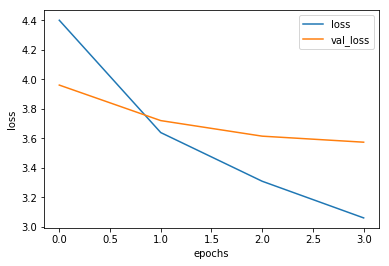

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [0]:
!mkdir dev
!wget -O dev/dev1.jpeg -q http://www.iro.umontreal.ca/~vaucher/History/Prehistoric_Craft/images/Titicaca_boat.jpg
!wget -O dev/dev2.jpeg -q  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTscwUyL3PfxSqHMpnAVmQF3uvB9BZ7X2Vw4i6vnbDD5NanlNB4X97ONxIw:https://dogsaholic.com/wp-content/uploads/2017/05/Best-Dog-For-Single-Man-2-810x431.jpg
#!wget -O dev/dev3.jpeg -q https://s3-eu-west-1.amazonaws.com/wbm.thumbnail/dissolve/1200/890884.jpg
!wget -O dev/dev3.jpeg -q https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQAoXz21uPgA67XB1tpjGuHNb7SVOQE9yZTC9ZuNXuHQ0kWP412ub5YuDlo:https://i.dawn.com/primary/2017/12/5a30e27f185ea.jpg
!wget -O dev/dev4.jpeg -q https://thebark.com/sites/default/files/styles/full/public/content/blog/full/dogs_and_keep_grass_green.jpg?itok=KtN0u1hO      

mkdir: cannot create directory ‘dev’: File exists


In [0]:
def getNextWords(image,in_text,n=1):
  sequence=  [word_to_ind[w] for w in in_text.split()]
  sequence = pad_sequences([sequence],MAX_SEQ_LEN)
  yhat = model.predict([image,sequence],verbose=0)
  topn = yhat.argsort()[0][-1*n:][::-1]
  probs = yhat[0][topn]
  return [ (ind_to_word[i],p) for i,p in zip(topn,probs) ]

In [0]:
def predict_caption(image_path):
    image = np.expand_dims(getImageFeature(image_path),axis=0)
    in_text = '<S>'
    while i in range(MAX_SEQ_LEN):
      nw = getNextWords(image,in_text,n=1)[0][0]
      in_text += ' '+nw
      if nw == "</S>":
          break
    return in_text
predict_caption('dev/dev1.jpeg')

'<S> man in kayak is on the water </S>'

In [0]:
def beam_search_caption(image_path, topn=5):
    image = np.expand_dims(getImageFeature(image_path),axis=0)
    beam = [ (1,'<S>') ]
    ans = []
    while len(beam)>0:
      cp,in_text = beam.pop(0)
      if len(in_text.split())>=MAX_SEQ_LEN:
        ans.append((cp,in_text))
        continue
      newwords  = getNextWords(image,in_text,n=3)
      for nw,prob in newwords:
        if nw == "</S>":
          ans.append( (cp*prob,in_text+" "+nw) )
        else:
          beam.append( (cp*prob,in_text+" "+nw) )
    return sorted(ans,key=lambda x:x[0],reverse=True)
predict_caption('dev/dev1.jpeg')

'<S> man in kayak is on the water </S>'

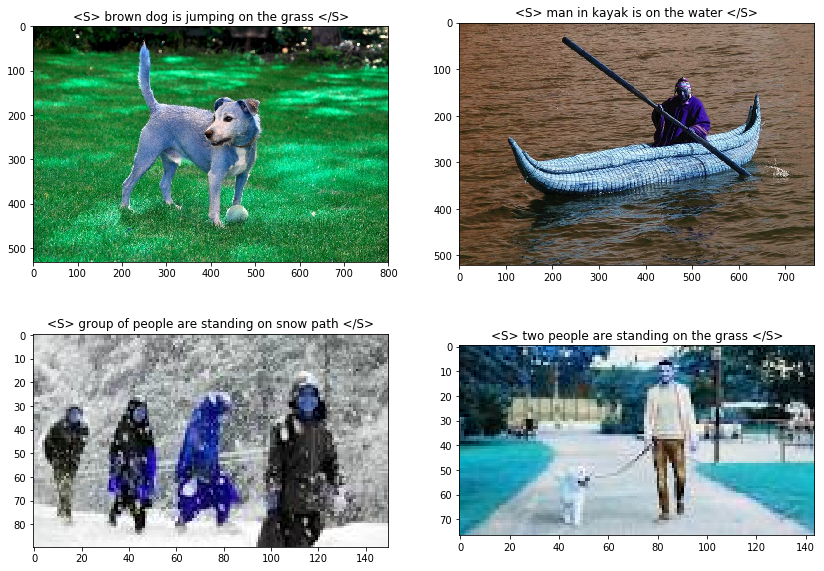

In [0]:
import glob
import cv2
%matplotlib inline
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(14,10))
i=0
for img in glob.glob('dev/*'):
  ax[i//2][i%2].imshow(cv2.imread(img))
  ax[i//2][i%2].set_title(predict_caption(img))
  i+=1

In [0]:

"https://keras.io/examples/pretrained_word_embeddings/"

'https://keras.io/examples/pretrained_word_embeddings/'

In [0]:
"https://github.com/hlamba28/Automatic-Image-Captioning/blob/master/Automatic%20Image%20Captioning.ipynb"
"https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8"